In [15]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import os
import lightnet as ln
from test_script import test_step
from utils import draw_bounding_boxes, intersection_over_union, to_pixel_coords
from lightnet.util import iou_cwh, iou_tlwh
from collections import Counter

In [4]:
TEST_IMG_DIR = "data/data_split/test/images"
TEST_LABEL_DIR =  "data/data_split/test/labels"
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

print(f"Using Device {DEVICE}")

model = ln.models.YoloV2(NUM_CLASSES)
model.load('models/5_epochs_split.pt', strict=False)
model.to(DEVICE)

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Using Device cuda


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [5]:
do_test = False
if do_test:
    test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=DEVICE
    )

In [6]:
model_2 = ln.models.YoloV2(NUM_CLASSES)
model_2.load('models/5_epochs_split.pt', strict=False)
model_2.to(DEVICE)

YoloV2(
  (backbone): FeatureExtractor(
    selection=[17_convbatch], return=True
    (module): Sequential(
      (1_convbatch): Conv2dBatchAct(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3_convbatch): Conv2dBatchAct(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (6_convbatch): Conv2dBatchAct(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), LeakyReLU(negative_slope=0.1, inplace=True))
      (7_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (8_m

In [7]:
GetBoxes_fn = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.5,
                network_stride=model.stride,
                anchors=model.anchors
            )

nms_fn = ln.data.transform.NMS(
    iou_thresh=.3,
    class_nms=True
)

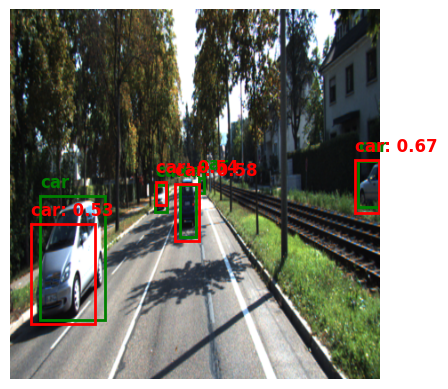

In [8]:
# good indexes: 785, 512

draw_bounding_boxes(index=785, 
                    model=model_2, 
                    dataset=test_dataset, 
                    GetBoxes_fn=GetBoxes_fn, 
                    nms_fn=nms_fn, 
                    class_names=["Cyclist", "Pedestrian", "car"], 
                    device=DEVICE)

In [9]:


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)
        

In [20]:
image, label = test_dataset[785]
model_input = image.unsqueeze(0).to(DEVICE)
model_2.to(DEVICE)
model_2.eval()

with torch.inference_mode():
    model_output = model_2(model_input)

box_tensor = GetBoxes_fn(model_output.cpu())
bboxes = nms_fn(box_tensor)


In [58]:
bboxes

tensor([[  0.0000, 401.6958, 198.9166,  26.7211,  60.1183,   0.6683,   2.0000],
        [  0.0000, 198.5423, 227.9210,  26.9997,  63.6332,   0.5809,   2.0000],
        [  0.0000, 169.4732, 206.3575,  11.0781,  26.1820,   0.5390,   2.0000],
        [  0.0000,  59.5102, 297.1416,  71.6959, 112.1295,   0.5274,   2.0000]])

In [ ]:
bboxes_pixel = []
for bbox in bboxes:
    x, y, h, w = to_pixel_coords(bbox[1:5], 1, 1)
    bboxes_pixel.append(
        [bbox[0].item(), 
         bbox[6].item(), 
         bbox[5].item() , 
         x.item(), 
         y.item(),
         h.item(), 
         w.item()])

In [60]:
bboxes_pixel

[[0.0,
  2.0,
  0.6682568788528442,
  388.335205078125,
  168.85740661621094,
  26.72113037109375,
  60.118316650390625],
 [0.0,
  2.0,
  0.5808943510055542,
  185.04241943359375,
  196.10438537597656,
  26.99969482421875,
  63.63316345214844],
 [0.0,
  2.0,
  0.5390462279319763,
  163.9341278076172,
  193.2664794921875,
  11.078094482421875,
  26.181976318359375],
 [0.0,
  2.0,
  0.527407705783844,
  23.662273406982422,
  241.0768585205078,
  71.69589233398438,
  112.12950134277344]]